In [37]:
!pip install cmake scipy pygame
!pip install gymnasium

  Obtaining dependency information for gymnasium from https://files.pythonhosted.org/packages/a8/4d/3cbfd81ed84db450dbe73a89afcd8bc405273918415649ac6683356afe92/gymnasium-0.29.1-py3-none-any.whl.metadata
  Using cached gymnasium-0.29.1-py3-none-any.whl.metadata (10 kB)
  Obtaining dependency information for farama-notifications>=0.0.1 from https://files.pythonhosted.org/packages/05/2c/ffc08c54c05cdce6fbed2aeebc46348dbe180c6d2c541c7af7ba0aa5f5f8/Farama_Notifications-0.0.4-py3-none-any.whl.metadata
  Using cached Farama_Notifications-0.0.4-py3-none-any.whl.metadata (558 bytes)
Using cached gymnasium-0.29.1-py3-none-any.whl (953 kB)
Using cached Farama_Notifications-0.0.4-py3-none-any.whl (2.5 kB)


In [38]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output
from time import sleep
from matplotlib import animation

State space: Discrete(500)
Action space: Discrete(6)
State: 472
Action: 4
Action mask: [0 1 1 0 1 0]
Reward: -1


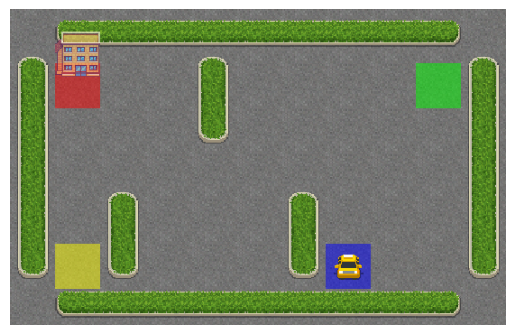

In [42]:
"""Initialize and validate the environment"""
env = gym.make("Taxi-v3", render_mode="rgb_array").env
state, _ = env.reset()

# Print dimensions of state and action space
print("State space: {}".format(env.observation_space))
print("Action space: {}".format(env.action_space))

# Sample random action
action = env.action_space.sample(env.action_mask(state))
next_state, reward, done, _, _ = env.step(action)

# Print output
print("State: {}".format(state))
print("Action: {}".format(action))
print("Action mask: {}".format(env.action_mask(state)))
print("Reward: {}".format(reward))

# Render and plot an environment frame
frame = env.render()
plt.imshow(frame)
plt.axis("off")
plt.show()

In [48]:
def run_animation(experience_buffer):
    """Function to run animation"""
    time_lag = 0.05  # Delay (in s) between frames
    for experience in experience_buffer:
        # Plot frame
        clear_output(wait=True)
        plt.imshow(experience['frame'])
        plt.axis('off')
        plt.show()

        # Print console output
        print(f"Episode: {experience['episode']}/{experience_buffer[-1]['episode']}")
        print(f"Epoch: {experience['epoch']}/{experience_buffer[-1]['epoch']}")
        print(f"State: {experience['state']}")
        print(f"Action: {experience['action']}")
        print(f"Reward: {experience['reward']}")
        # Pauze animation
        sleep(time_lag)

In [49]:
def store_episode_as_gif(experience_buffer, path='./', filename='animation.gif'):
    """Store episode as gif animation"""
    fps = 5   # Set framew per seconds
    dpi = 300  # Set dots per inch
    interval = 50  # Interval between frames (in ms)

    # Retrieve frames from experience buffer
    frames = []
    for experience in experience_buffer:
        frames.append(experience['frame'])

    # Fix frame size
    plt.figure(figsize=(frames[0].shape[1] / dpi, frames[0].shape[0] / dpi), dpi=dpi)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    # Generate animation
    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=interval)

    # Save output as gif
    anim.save(path + filename, writer='imagemagick', fps=fps)

### Testing a random agent

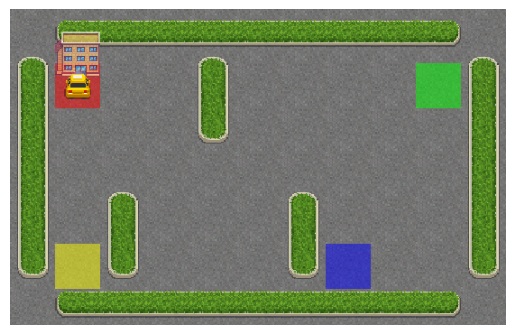

Episode: 1/1
Epoch: 2443/2443
State: 0
Action: 5
Reward: -9803
# epochs: 2444
# failed drop-offs: 820


In [50]:
"""Simulation with random agent"""
epoch = 0
num_failed_dropoffs = 0
experience_buffer = []
cum_reward = 0

done = False

state, _ = env.reset()

while not done:
    # Sample random action
    "Action selection without action mask"
    action = env.action_space.sample()

    "Action selection with action mask"
    #action = env.action_space.sample(env.action_mask(state))

    state, reward, done, _, _ = env.step(action)
    cum_reward += reward

    # Store experience in dictionary
    experience_buffer.append({
        "frame": env.render(),
        "episode": 1,
        "epoch": epoch,
        "state": state,
        "action": action,
        "reward": cum_reward,
        }
    )

    if reward == -10:
        num_failed_dropoffs += 1

    epoch += 1

# Run animation and print console output
run_animation(experience_buffer)

print("# epochs: {}".format(epoch))
print("# failed drop-offs: {}".format(num_failed_dropoffs))

### Training the agent

In [57]:
"""Training the agent"""
q_table = np.zeros([env.observation_space.n, env.action_space.n])

In [58]:
# Hyperparameters
alpha = 0.1  # Learning rate
gamma = 1.0  # Discount rate
epsilon = 0.1  # Exploration rate
num_episodes = 10000  # Number of episodes

# Output for plots
cum_rewards = np.zeros([num_episodes])
total_epochs = np.zeros([num_episodes])

In [59]:
for episode in range(1, num_episodes+1):
    # Reset environment
    state, info = env.reset()
    epoch = 0 
    num_failed_dropoffs = 0
    done = False
    cum_reward = 0

    while not done:
        
        if random.uniform(0, 1) < epsilon:
            "Basic exploration [~0.47m]"
            action = env.action_space.sample() # Sample random action (exploration)
            
            "Exploration with action mask [~1.52m]"
          # action = env.action_space.sample(env.action_mask(state)) "Exploration with action mask"
        else:      
            "Exploitation with action mask [~1m52s]"
           # action_mask = np.where(info["action_mask"]==1,0,1) # invert
           # masked_q_values = np.ma.array(q_table[state], mask=action_mask, dtype=np.float32)
           # action = np.ma.argmax(masked_q_values, axis=0)

            "Exploitation with random tie breaker [~1m19s]"
          #  action = np.random.choice(np.flatnonzero(q_table[state] == q_table[state].max()))
            
            "Basic exploitation [~47s]"
            action = np.argmax(q_table[state]) # Select best known action (exploitation)
 
        next_state, reward, done, _ , info = env.step(action) 

        cum_reward += reward
        
        old_q_value = q_table[state, action]
        next_max = np.max(q_table[next_state])
        
        new_q_value = (1 - alpha) * old_q_value + alpha * (reward + gamma * next_max)
        
        q_table[state, action] = new_q_value
        
        if reward == -10:
            num_failed_dropoffs += 1

        state = next_state
        epoch += 1
        
        total_epochs[episode-1] = epoch
        cum_rewards[episode-1] = cum_reward

    if episode % 100 == 0:
        clear_output(wait=True)
        print(f"Episode #: {episode}")

print("\n")
print("===Training completed.===\n")

Episode #: 10000


===Training completed.===



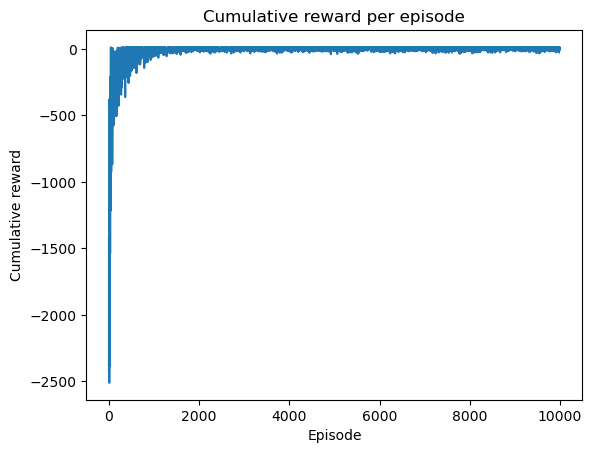

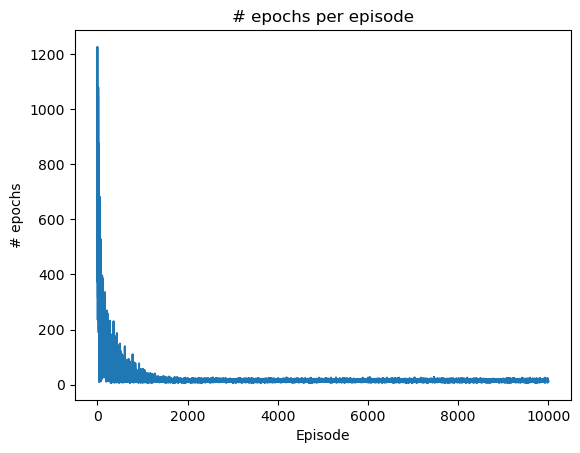

In [54]:
# Plot reward convergence
plt.title("Cumulative reward per episode")
plt.xlabel("Episode")
plt.ylabel("Cumulative reward")
plt.plot(cum_rewards)
plt.show()

# Plot epoch convergence
plt.title("# epochs per episode")
plt.xlabel("Episode")
plt.ylabel("# epochs")
plt.plot(total_epochs)
plt.show()

### Testing the policy

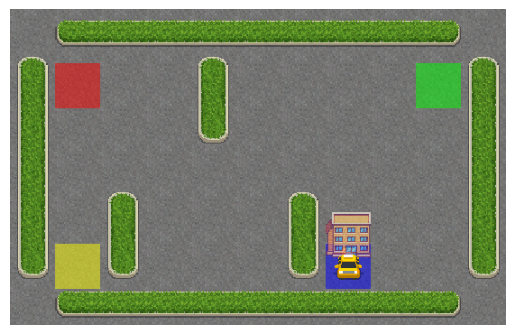

Episode: 1/1
Epoch: 14/14
State: 475
Action: 5
Reward: 7


In [60]:
"""Test policy performance after training"""

num_epochs = 0
total_failed_deliveries = 0
num_episodes = 1
experience_buffer = []
store_gif = True

for episode in range(1, num_episodes+1):
    # Initialize experience buffer

    my_env = env.reset()
    state = my_env[0]
    epoch = 1 
    num_failed_deliveries =0
    cum_reward = 0
    done = False

    while not done:
        action = np.argmax(q_table[state])
        state, reward, done, _, _ = env.step(action)
        cum_reward += reward

        if reward == -10:
            num_failed_deliveries += 1

        # Store rendered frame in animation dictionary
        experience_buffer.append({
            'frame': env.render(),
            'episode': episode,
            'epoch': epoch,
            'state': state,
            'action': action,
            'reward': cum_reward
            }
        )

        epoch += 1

    total_failed_deliveries += num_failed_deliveries
    num_epochs += epoch

    if store_gif:
        store_episode_as_gif(experience_buffer)

# Run animation and print output
run_animation(experience_buffer)

In [56]:
# Print final results
print("\n") 
print(f"Test results after {num_episodes} episodes:")
print(f"Mean # epochs per episode: {num_epochs / num_episodes}")
print(f"Mean # failed drop-offs per episode: {total_failed_deliveries / num_episodes}")



Test results after 1 episodes:
Mean # epochs per episode: 15.0
Mean # failed drop-offs per episode: 0.0
